In [1]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


In [3]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, ts_dir, tr_split):
    # train and validation dataframe
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= tr_split, shuffle= True, random_state= 123, stratify= strat)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [4]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [17]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.dwell = dwell
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        if self.base_model != None:
            status = base_model.trainable
            if status:
                msg = ' initializing callback starting training with base_model trainable'
            else:
                msg = 'initializing callback starting training with base_model not trainable'
        else:
            msg = 'initialing callback and starting training'
        print(msg)

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    # Define a function that will run after training
    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg = f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print(msg)

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

    # Define a function of batches that will run during the epoch
    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100  # get training accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    # Define a function which define the time of epoch starting
    def on_epoch_begin(self, epoch, logs= None):
        self.now = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        later = time.time()
        duration = later - self.now

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg = 'enter H to halt training, F to fine tune model, or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans == 'f':
                        if base_model.trainable:
                            msg = 'base_model is already set as trainable'
                        else:
                            msg = 'setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable = True
                        print(msg)
                        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg)
                        self.count = 0
                        self.stop_count = 0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial
                    else:
                        ans = int(ans)
                        self.ask_epoch += ans
                        msg = f' training will continue until epoch ' + str(self.ask_epoch)
                        print(msg)
                        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                        print(msg)

In [7]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Found 1033 validated image filenames belonging to 2 classes.
Found 115 validated image filenames belonging to 2 classes.
Found 545 validated image filenames belonging to 2 classes.


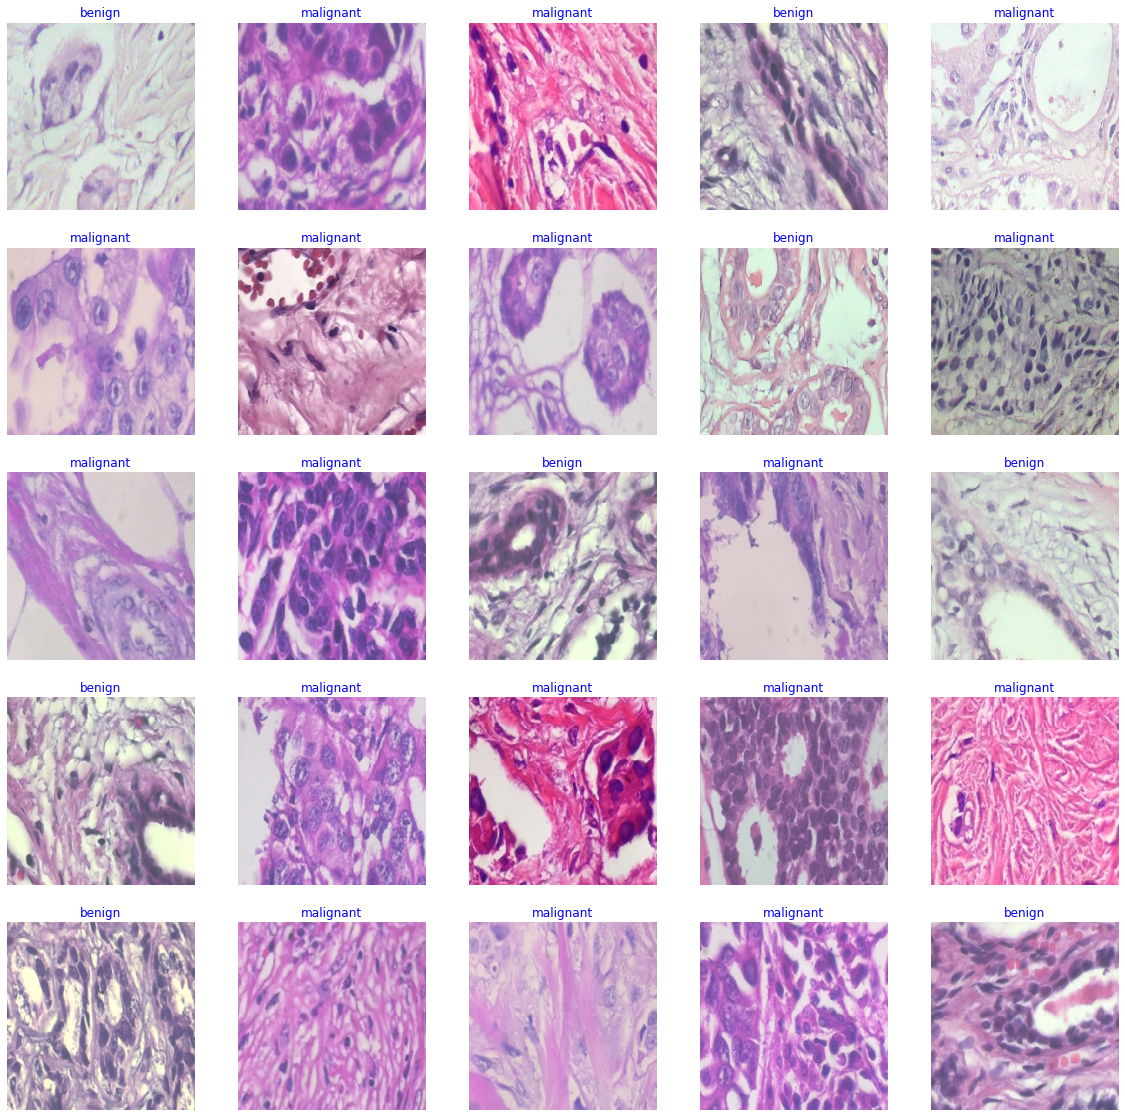

In [9]:
# Get Dataframes
train_dir = r'../input/breakhis-400x/BreaKHis 400X/train'
test_dir = r'../input/breakhis-400x/BreaKHis 400X/test'
train_df, valid_df, test_df = create_df(train_dir, test_dir, tr_split= 0.9)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [14]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization_2 (Batch (None, 1536)              6144      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 11,183,665
Trainable params: 11,093,290
Non-trainable params: 90,375
_________________________________________________________________


In [18]:
batch_size = 40
epochs = 40
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
dwell = True 		# experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            dwell= dwell, batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

In [19]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

 initializing callback starting training with base_model trainable
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     6.238   91.191   6.90344  72.174   0.00100  0.00100  val_loss     0.00    18.52  
 2 /40     5.357   94.095   6.48175  71.304   0.00100  0.00100  val_loss     6.11    17.82  
 3 /40     4.657   95.063   5.31606  73.043   0.00100  0.00100  val_loss    17.98    18.46  
 4 /40     4.074   97.580   4.58372  74.783   0.00100  0.00100  val_loss    13.78    17.86  
 5 /40     3.586   98.742   3.86095  81.739   0.00100  0.00100  val_loss    15.77    18.52  
enter H to halt training or an integer for number of epochs to run then ask again


 10


 training will continue until epoch 15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     3.191   98.742   3.42543  83.478   0.00100  0.00100  val_loss    11.28    18.53  
 7 /40     2.855   98.451   2.88600  88.696   0.00100  0.00100  val_loss    15.75    17.82  
 8 /40     2.549   98.935   2.51714  94.783   0.00100  0.00100  val_loss    12.78    18.60  
 9 /40     2.297   98.742   2.25136  96.522   0.00100  0.00100  val_loss    10.56    18.15  
10 /40     2.082   99.516   2.04772  96.522   0.00100  0.00100  val_loss     9.05    18.15  
11 /40     1.905   98.645   1.88137  95.652   0.00100  0.00100  val_loss     8.12    18.25  
12 /40     1.719   99.806   1.70349  95.652   0.00100  0.00100  val_loss     9.45    17.86  
13 /40     1.579   99.129   1.55645  96.522   0.00100  0.00100  val_loss     8.63    18.30  
14 /40     1.447   99.226   1.43338  95.652   0.00100  0.00100  val_loss     7.91    18.10  
15 /40     1.320   99.710   1.31

 5


 training will continue until epoch 20
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
16 /40     1.211   99.710   1.19445  98.261   0.00100  0.00100  val_loss     9.16    18.57  
17 /40     1.113   99.710   1.10173  96.522   0.00100  0.00100  val_loss     7.76    17.78  
18 /40     1.028   99.322   1.00147  98.261   0.00100  0.00100  val_loss     9.10    18.37  
19 /40     0.944   99.516   0.93696  98.261   0.00100  0.00100  val_loss     6.44    18.20  
20 /40     0.873   99.613   0.88171  95.652   0.00100  0.00100  val_loss     5.90    17.93  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 25
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
21 /40     0.805   99.710   0.78736  100.000  0.00100  0.00100  val_loss    10.70    18.59  
22 /40     0.728   100.000  0.72157  98.261   0.00100  0.00100  val_loss     8.36    18.57  
23 /40     0.680   99.710   0.67049  98.261   0.00100  0.00100  val_loss     7.08    18.13  
24 /40     0.623   100.000  0.62566  98.261   0.00100  0.00100  val_loss     6.69    18.48  
25 /40     0.585   99.129   0.59874  95.652   0.00100  0.00100  val_loss     4.30    17.90  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 30
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
26 /40     0.530   100.000  0.54310  98.261   0.00100  0.00100  val_loss     9.29    18.85  
27 /40     0.492   99.710   0.49305  97.391   0.00100  0.00100  val_loss     9.22    18.80  
28 /40     0.456   99.903   0.46631  97.391   0.00100  0.00100  val_loss     5.42    18.54  
29 /40     0.418   99.903   0.43555  98.261   0.00100  0.00100  val_loss     6.60    17.98  
30 /40     0.391   99.806   0.41718  96.522   0.00100  0.00100  val_loss     4.22    18.71  
enter H to halt training or an integer for number of epochs to run then ask again


 10


 training will continue until epoch 40
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
31 /40     0.369   99.806   0.36612  99.130   0.00100  0.00100  val_loss    12.24    18.92  
32 /40     0.337   99.903   0.34603  97.391   0.00100  0.00100  val_loss     5.49    18.34  
33 /40     0.336   98.935   0.34738  97.391   0.00100  0.00050  val_loss    -0.39    18.48  
34 /40     0.317   99.806   0.33211  99.130   0.00050  0.00050  val_loss     4.02    18.35  
35 /40     0.305   100.000  0.32419  98.261   0.00050  0.00050  val_loss     2.38    18.32  
36 /40     0.296   99.903   0.31494  99.130   0.00050  0.00050  val_loss     2.85    18.63  
37 /40     0.292   99.516   0.30594  98.261   0.00050  0.00050  val_loss     2.86    18.09  
38 /40     0.277   99.806   0.30120  97.391   0.00050  0.00050  val_loss     1.55    18.62  
39 /40     0.270   99.710   0.29013  97.391   0.00050  0.00050  val_loss     3.68    18.30  
40 /40     0.260   99.903   0.27

 h


training has been halted at epoch 40 due to user input
Training is completed - model is set with weights from epoch 40 
training elapsed time was 0.0 hours, 34.0 minutes, 38.93 seconds)


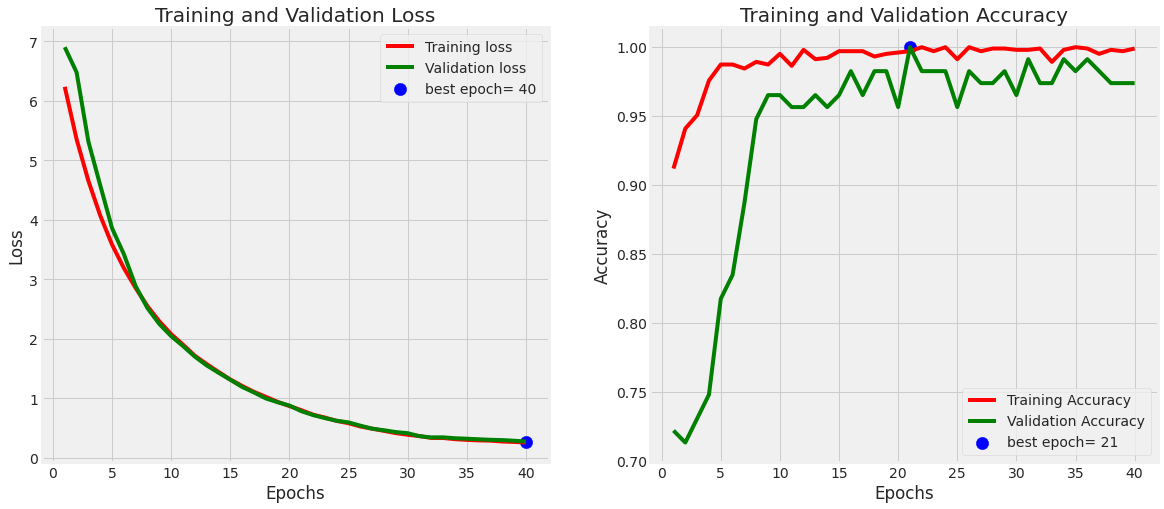

In [20]:
plot_training(history)

In [21]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

109/109 [==============================] - 15s 137ms/step - loss: 0.3528 - accuracy: 0.9413
Train Loss:  0.23719504475593567
Train Accuracy:  1.0
--------------------
Validation Loss:  0.27693992853164673
Validation Accuracy:  0.9739130139350891
--------------------
Test Loss:  0.3527882695198059
Test Accuracy:  0.9412844181060791


In [22]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix, Without Normalization
[[152  24]
 [  8 361]]
              precision    recall  f1-score   support

      benign       0.95      0.86      0.90       176
   malignant       0.94      0.98      0.96       369

    accuracy                           0.94       545
   macro avg       0.94      0.92      0.93       545
weighted avg       0.94      0.94      0.94       545



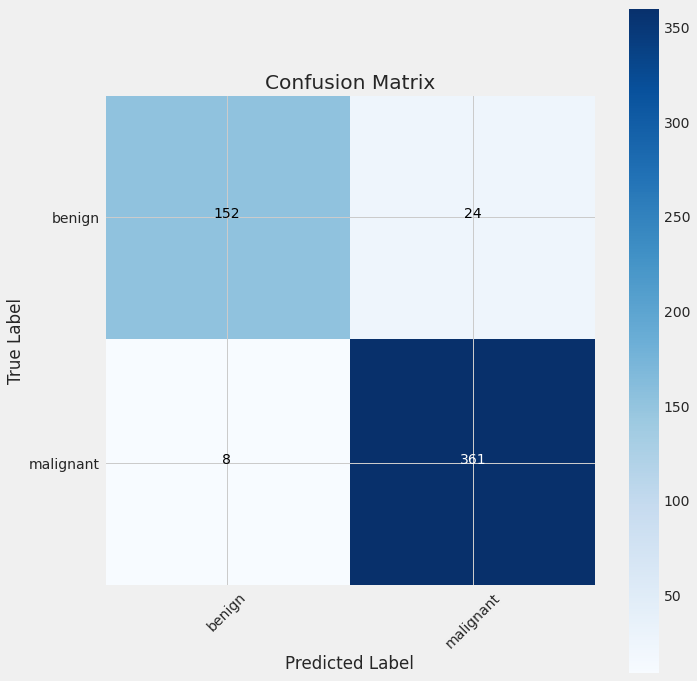

In [24]:
target_names = ['benign', 'malignant']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [27]:
model_name = 'EfficientNetB3'
subject = 'Breast Cancer'
save_path = './'
acc = test_score[1] * 100

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

model was saved as ./EfficientNetB3-Breast Cancer-94.13.h5


In [28]:
class_dict = train_gen.class_indices
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
subject = 'Breast Cancer'
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as ./Breast Cancer-class_dict.csv
